In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
# import Tool
import numpy as np
import tqdm
import tejapi
from datetime import datetime, timedelta

In [36]:
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.family'] = 'Microsoft JhengHei' 
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')

In [6]:
twse = tejapi.get('TWN/APIPRCD', coid='IX0001',opts={'columns': ['mdate','roi','close_d','vol','low_d','open_d','high_d']}, mdate={'gte': '2010-01-01', 'lte':'2025-04-21'}, paginate=True)

In [7]:
twse['roi'] = (twse['roi'] / 100).shift(-2)
twse.set_index('mdate', inplace=True)

In [8]:
price_df = twse.rename(columns={
    "open_d": "open",
    "high_d": "high",
    "low_d": "low",
    "close_d": "close",
    "vol": "volume"  # 不需改名就保留
}).drop(columns=["open", "high", "low", "roi","volume"])

<Axes: title={'center': '傳統MA均線'}, xlabel='mdate'>

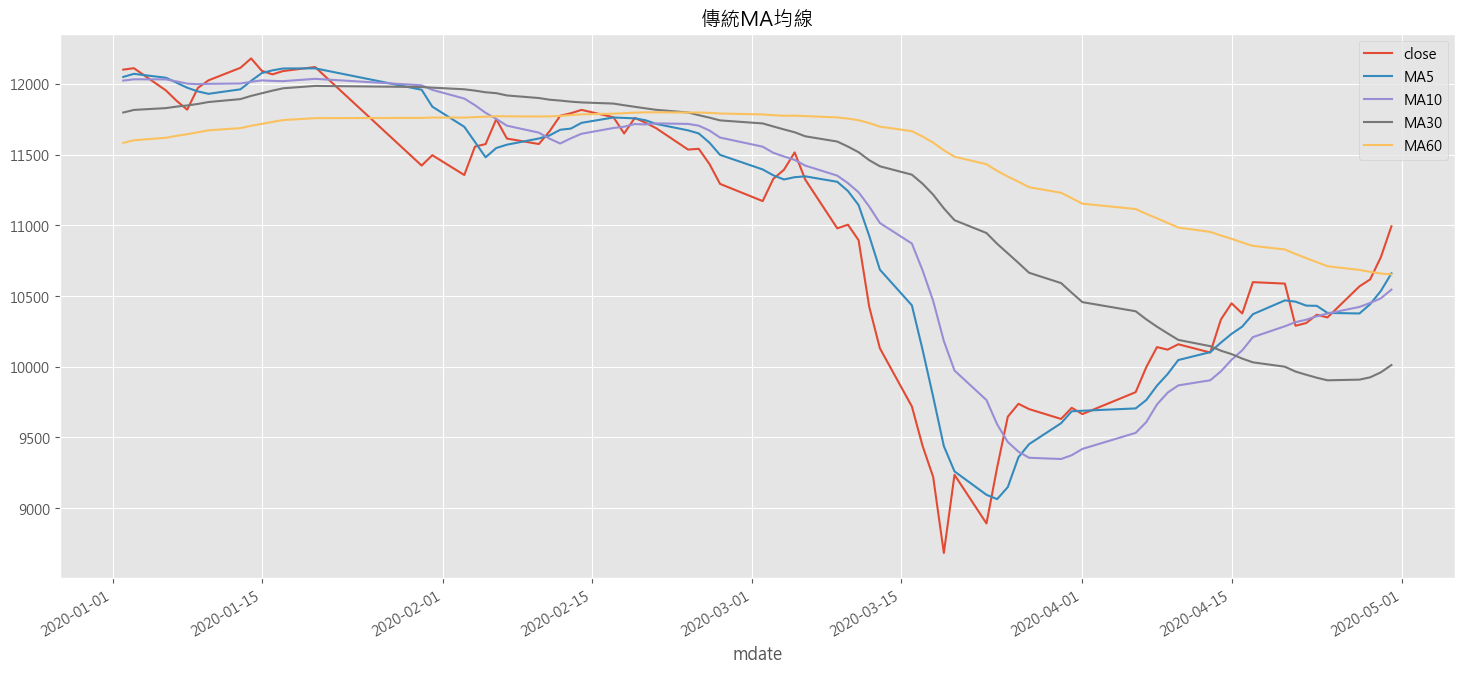

In [9]:
start_date = '2020-01-01'
end_date = '2020-05-01'
for i in [5,10,30,60]:
    price_df[f'MA%d'%i] = price_df['close'].rolling(i).mean()
price_df.loc[start_date:end_date].plot(figsize=(18,8),title='傳統MA均線')

<Axes: title={'center': '趨勢線比較'}, xlabel='mdate'>

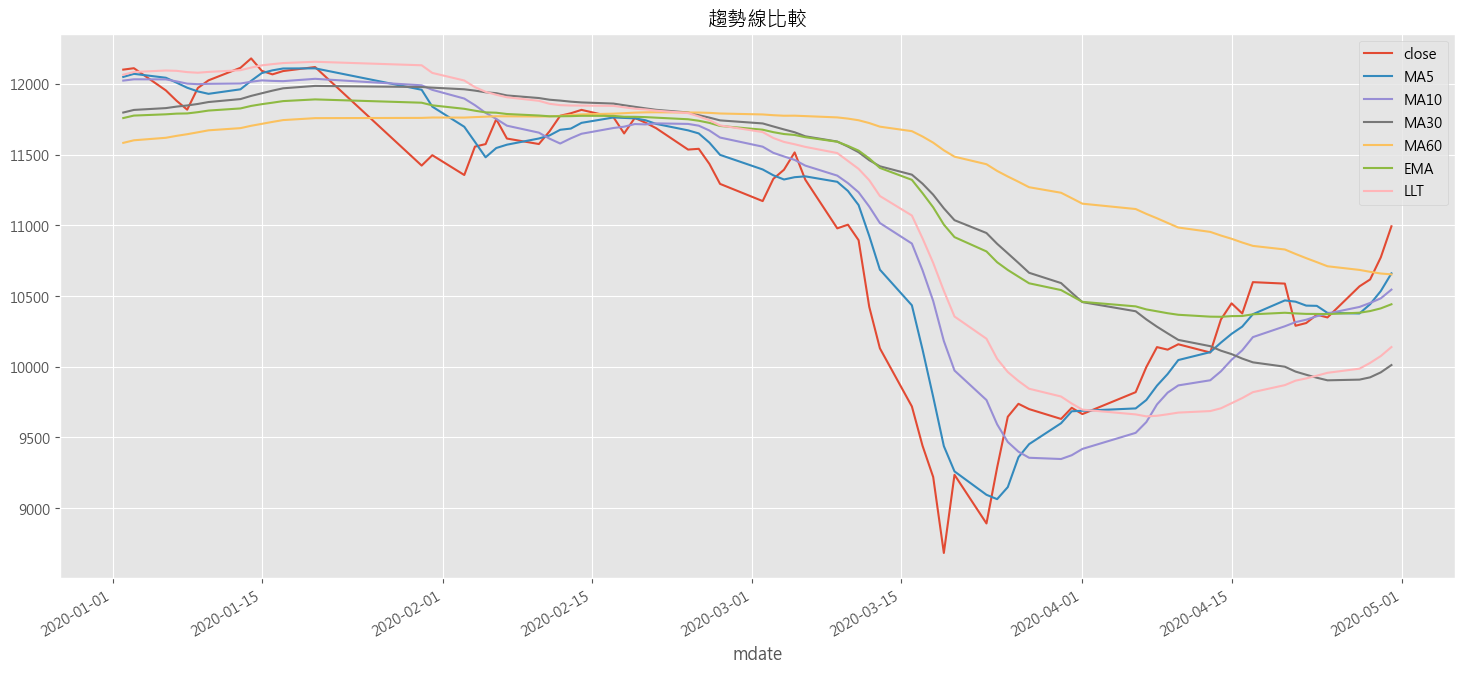

In [10]:
def cal_LLT(price: pd.Series, alpha: float):
    
    LLT = []
    price_value = price.values
    LLT.append(price_value[0])
    LLT.append(price_value[1])


    for i, e in enumerate(price_value):
        if i > 1:

            v = (alpha - alpha**2 / 4) * e + (alpha**2 / 2) * price_value[i - 1] - (
                alpha - 3 * (alpha**2) / 4) * price_value[i - 2] + 2 * (
                    1 - alpha) * LLT[i - 1] - (1 - alpha)**2 * LLT[i - 2]

            LLT.append(v)

    return LLT
price_df['EMA'] = price_df['close'].ewm(alpha=0.05,adjust=False).mean()
price_df['MA30'] = price_df['close'].rolling(30).mean()
price_df['LLT'] = cal_LLT(price_df['close'],0.05)
price_df.loc[start_date:end_date].plot(figsize=(18,8),title='趨勢線比較')

<Axes: title={'center': '不同α參數的趨勢線'}, xlabel='mdate'>

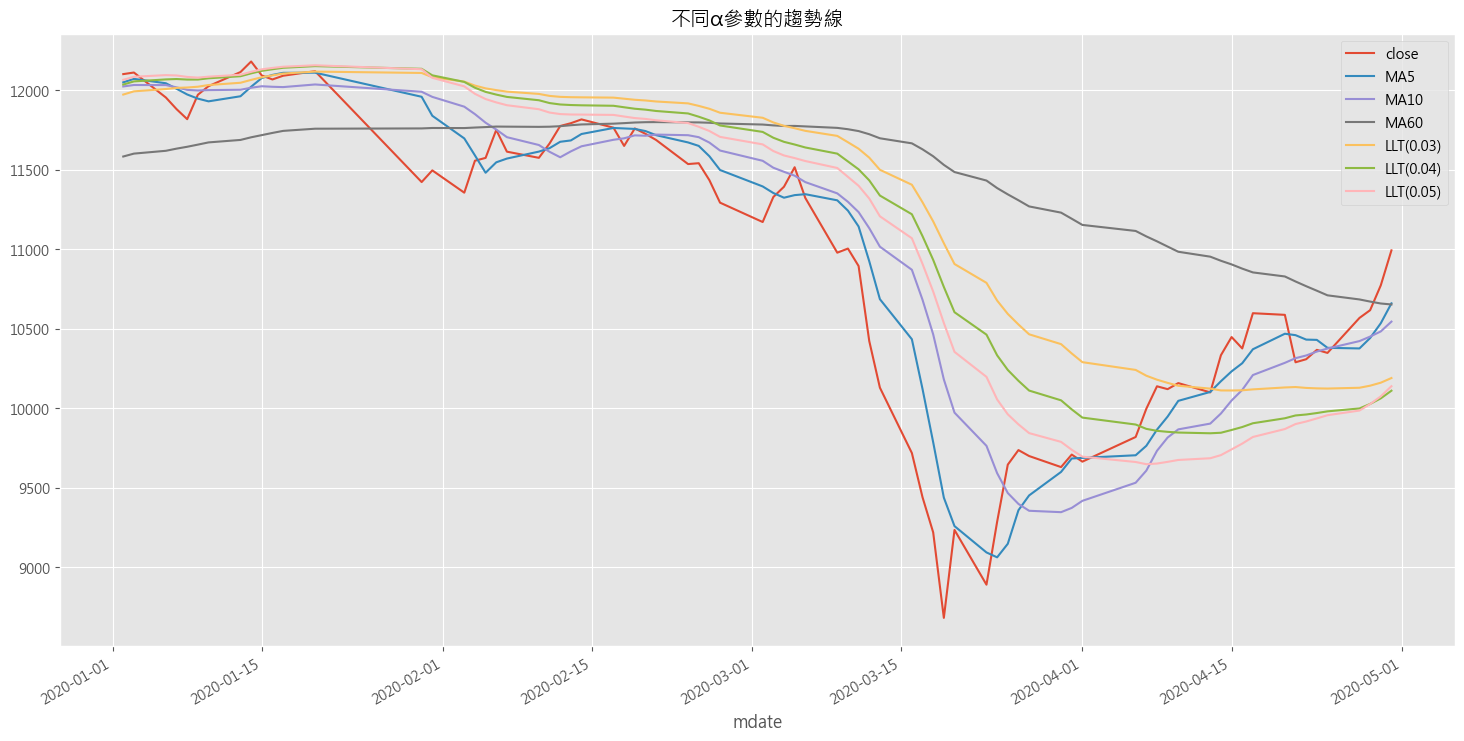

In [11]:
price_df.drop(columns=['EMA','MA30','LLT'],inplace=True)

for a in [0.03,0.04,0.05]:
    
    price_df[f'LLT(%s)'%a] = cal_LLT(price_df['close'],a)
    
price_df.loc[start_date:end_date].plot(figsize=(18,9),title='不同α參數的趨勢線') 

In [12]:
alpha_all = [2/(d+1) for d in range(20,91,10)]

for a in alpha_all:
    price_df[f'LLT(%0.5s)'%a] = cal_LLT(price_df['close'],a)

In [13]:
diff_llt = price_df[[f'LLT(%0.5s)'%(2/(d+1)) for d in range(20,91,10)]].diff().shift(1)

cond = ((diff_llt>0)*1+(diff_llt<0)*-1)
ret_sreies = price_df['close'].pct_change()
ret_shape = np.broadcast_to(np.expand_dims(ret_sreies.values,1),diff_llt.shape)
strategy_ret = cond*ret_shape
strategy_cum = (1+strategy_ret).cumprod()

<Axes: title={'center': 'LLT採用切線法開平倉'}, xlabel='mdate'>

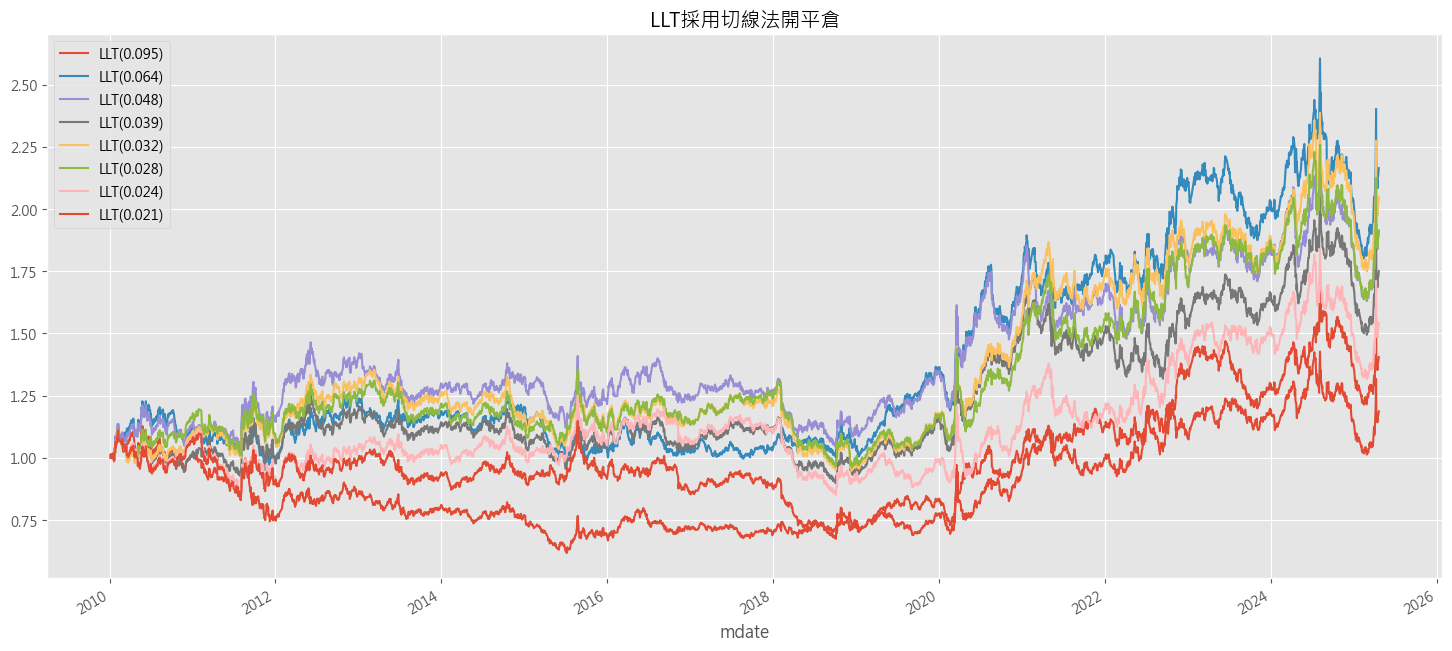

In [14]:
strategy_cum.plot(figsize=(18,8),title='LLT採用切線法開平倉')

<BarContainer object of 8 artists>

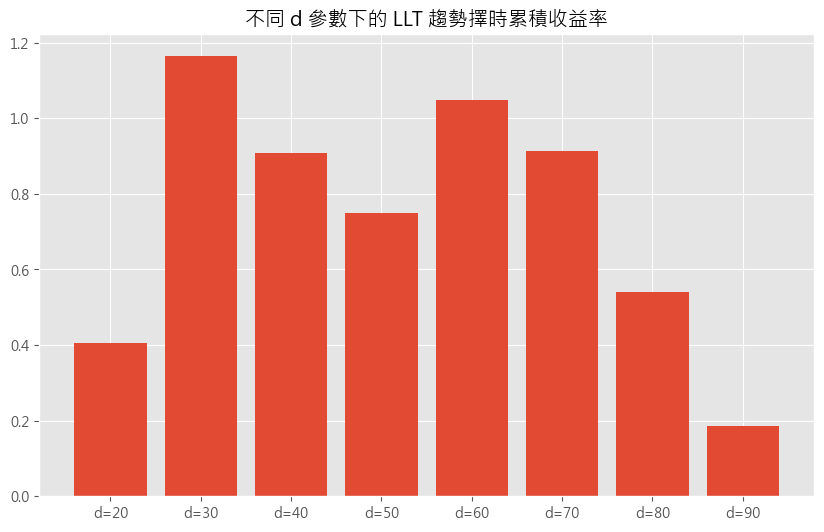

In [15]:
plt.figure(figsize=(10,6))
plt.title('不同 d 參數下的 LLT 趨勢擇時累積收益率')
plt.bar(x=[f'd=%s'%x for x in range(20,91,10)],height=(strategy_cum.iloc[-1]-1).values)

In [16]:
def cal_shope(arr):
    
    return np.mean(arr[1:])/np.mean(arr[:-1])

In [17]:
shope_df = price_df[[f'LLT(%0.5s)' % (2 / (d + 1)) for d in range(20, 91, 10)
                    ]].rolling(22).apply(
                        cal_shope, raw=True)
                        
cond = (shope_df > 1) * 1 + (shope_df < 1) * -1
strategy_ret_a = cond * ret_shape
strategy_cum_a = (1 + strategy_ret_a).cumprod()

<Axes: title={'center': 'LLT斜率開平倉'}, xlabel='mdate'>

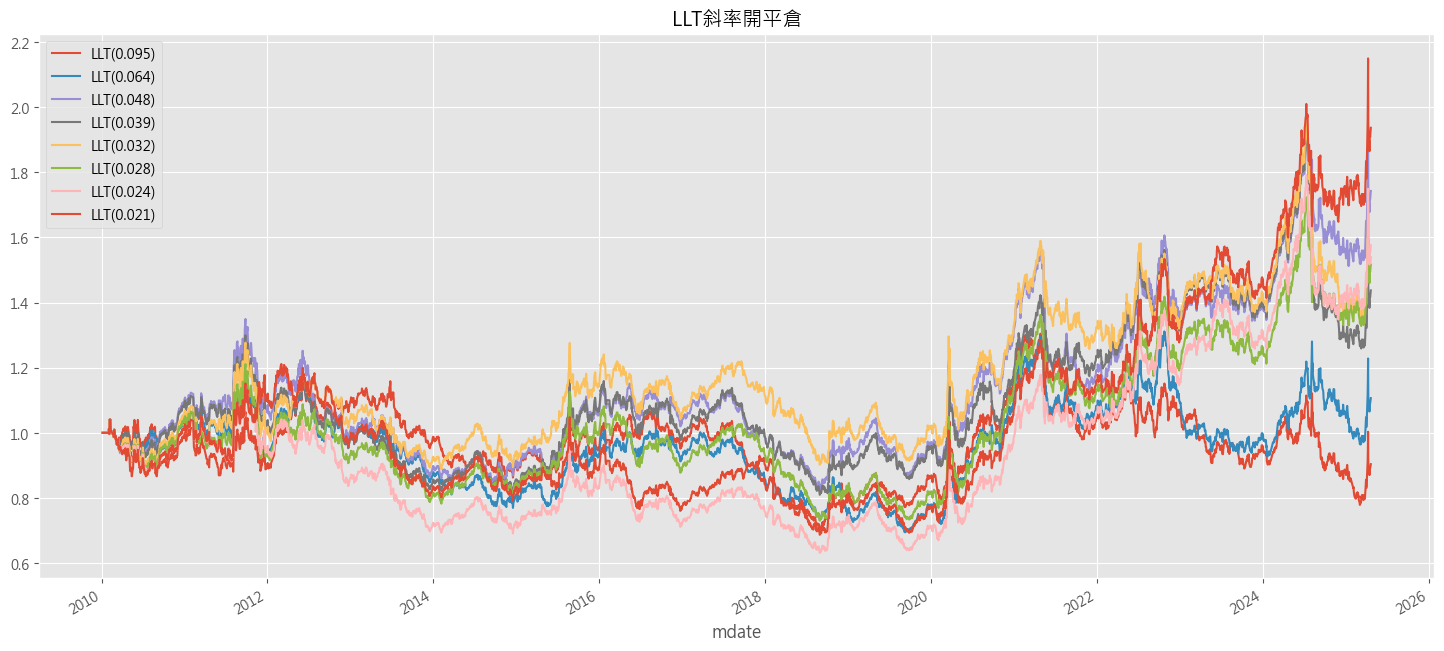

In [18]:
strategy_cum_a.plot(figsize=(18,8),title='LLT斜率開平倉')

<BarContainer object of 8 artists>

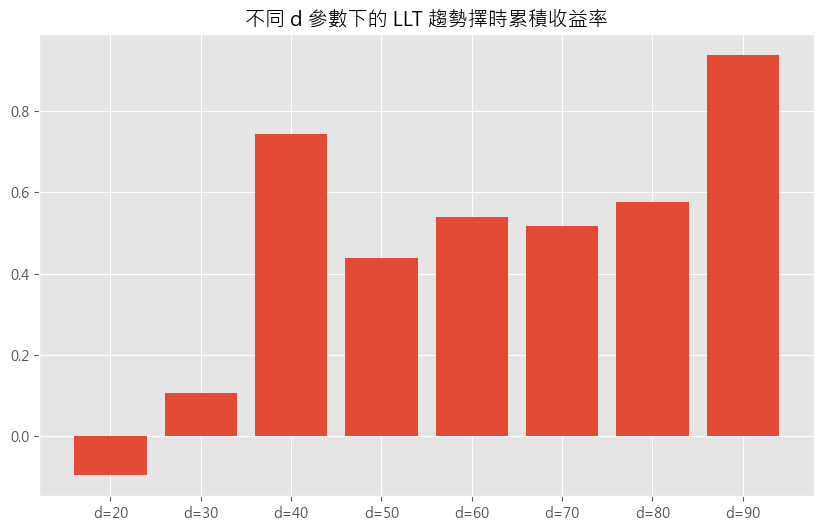

In [19]:
plt.figure(figsize=(10,6))
plt.title('不同 d 參數下的 LLT 趨勢擇時累積收益率')
plt.bar(x=[f'd=%s'%x for x in range(20,91,10)],height=(strategy_cum_a.iloc[-1]-1).values)

In [20]:
# 計算 FRAMA（Fractal Adaptive Moving Average）均線
def FRAMA(se, periods, clip=True):

    T = int(periods / 2)
    df = se.copy()

    # 1. 使用長度為 T 的窗口計算 N1 = (最高價 – 最低價) / T
    N1 = (df.rolling(T).max() - df.rolling(T).min()) / T

    # 2. 將資料向後平移 T 期後，再計算 N2 = (最高價 – 最低價) / T
    n2_df = df.shift(T)
    N2 = (n2_df.rolling(T).max() - n2_df.rolling(T).min()) / T

    # 3. 使用長度為 periods 的窗口計算 N3 = (最高價 – 最低價) / (2T)
    N3 = (df.rolling(periods).max() - df.rolling(periods).min()) / periods

    # 4. 計算分形維度 D = [log(N1+N2) – log(N3)] / log(2)
    D = (np.log10(N1 + N2) - np.log10(N3)) / np.log10(2)

    # 5. 根據分形維度 D 計算 EMA 的自適應係數 alpha = exp(-4.6 * (D - 1))
    alpha = np.exp(-4.6 * (D - 1))

    # 可選擇是否將 alpha 限制在一定範圍內（例如 0.01 到 0.2）
    if clip:
        alpha = np.clip(alpha, 0.01, 0.2)

    # 6. 使用自訂的 alpha 進行遞迴式 EMA 計算
    FRAMA = []
    idx = min(np.argwhere(~np.isnan(alpha))) - 1  # 找到第一個非 NaN 的位置

    for row, data in enumerate(alpha):
        if row == idx:
            FRAMA.append(df.iloc[row])  # 初始值直接使用原始資料
        elif row > idx:
            # FRAMA[t] = alpha[t] * price[t] + (1 - alpha[t]) * FRAMA[t-1]
            FRAMA.append(data * df.iloc[row] + (1 - data) * FRAMA[-1])
        else:
            FRAMA.append(np.nan)  # 尚未有足夠資料時，設為 NaN

    FRAMA_se = pd.Series(FRAMA, index=df.index)

    return FRAMA_se


In [21]:
frama_df = pd.DataFrame()
for d in range(20,91,10):
    frama_df['FRAMA(d=%s)'%d] = FRAMA(price_df['close'],d)

<Axes: title={'center': 'FRAMA切線法'}, xlabel='mdate'>

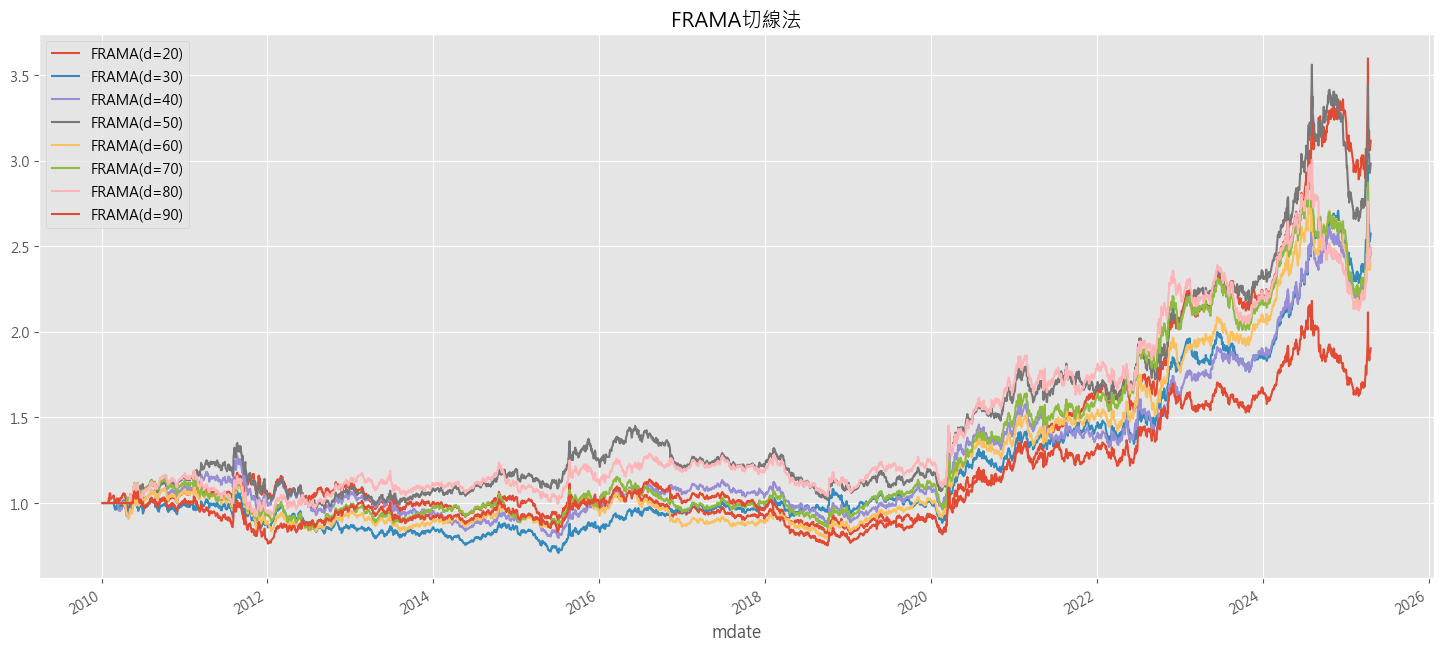

In [22]:
diff_frama = frama_df[[f'FRAMA(d=%s)'%d for d in range(20,91,10)]].diff().shift(1)

cond = ((diff_frama>0)*1+(diff_frama<0)*-1)
ret_sreies = price_df['close'].pct_change()
ret_shape = np.broadcast_to(np.expand_dims(ret_sreies.values,1),diff_frama.shape)
strategy_ret_b = cond*ret_shape
strategy_cum_b = (1+strategy_ret_b).cumprod()
strategy_cum_b.plot(figsize=(18,8),title='FRAMA切線法')

<Axes: title={'center': 'FRAMA斜率'}, xlabel='mdate'>

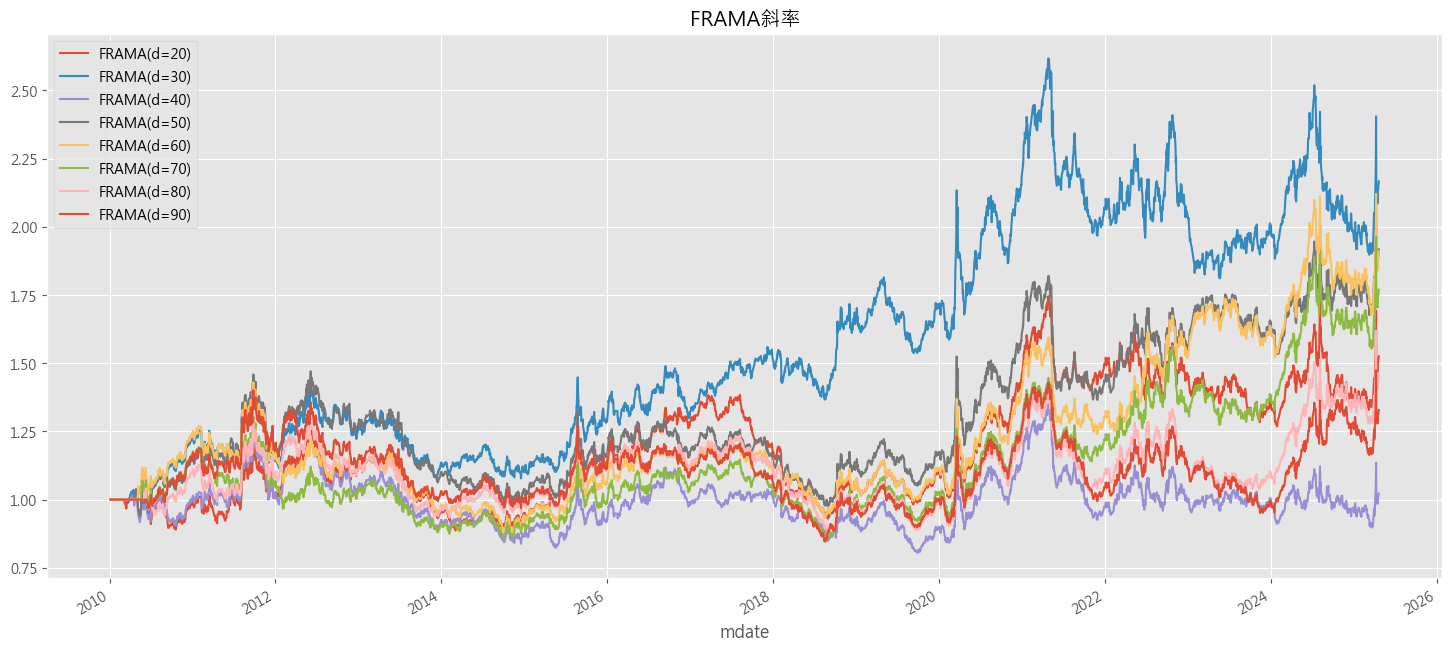

In [23]:
shope_df = frama_df[[f'FRAMA(d=%s)' % d for d in range(20, 91, 10)
                    ]].rolling(22).apply(
                        cal_shope, raw=True)
                        
cond = (shope_df > 1) * 1 + (shope_df < 1) * -1
strategy_ret_c = cond * ret_shape
strategy_cum_c = (1 + strategy_ret_c).cumprod()
strategy_cum_c.plot(figsize=(18,8),title='FRAMA斜率')

<Axes: title={'center': 'HMA切線法'}, xlabel='mdate'>

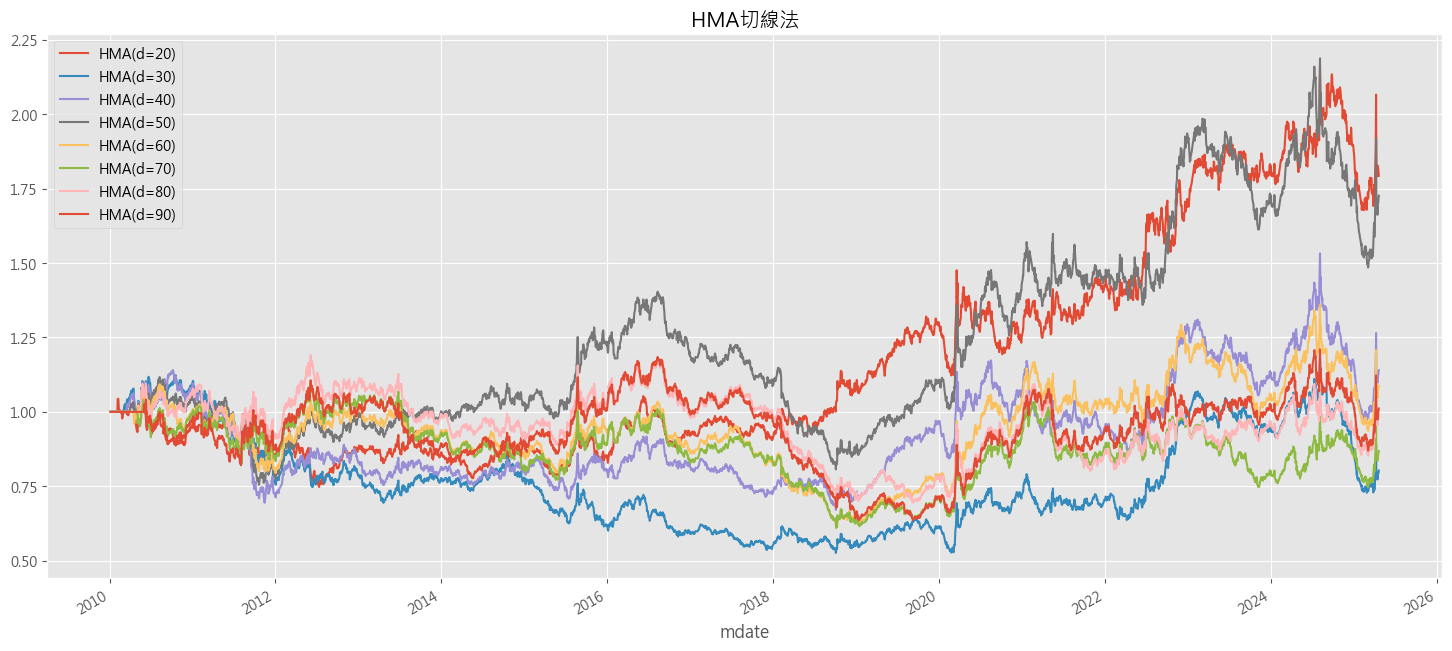

In [24]:
import talib
from math import sqrt
def HMA(se, periods):
    
    close = se.values
    hma = talib.WMA(2*talib.WMA(close, int(periods/2)) -
                    talib.WMA(close, periods), int(sqrt(periods)))

    return pd.Series(hma, index=se.index)

hma_df = pd.DataFrame()
for d in range(20,91,10):
    hma_df['HMA(d=%s)'%d] = HMA(price_df['close'],d)
    
diff_hma = hma_df[[f'HMA(d=%s)'%d for d in range(20,91,10)]].diff().shift(1)

cond = ((diff_hma>0)*1+(diff_hma<0)*-1)
ret_sreies = price_df['close'].pct_change()
ret_shape = np.broadcast_to(np.expand_dims(ret_sreies.values,1),diff_hma.shape)
strategy_ret_d = cond*ret_shape
strategy_cum_d = (1+strategy_ret_d).cumprod()
strategy_cum_d.plot(figsize=(18,8),title='HMA切線法')

<Axes: title={'center': 'HMA斜率'}, xlabel='mdate'>

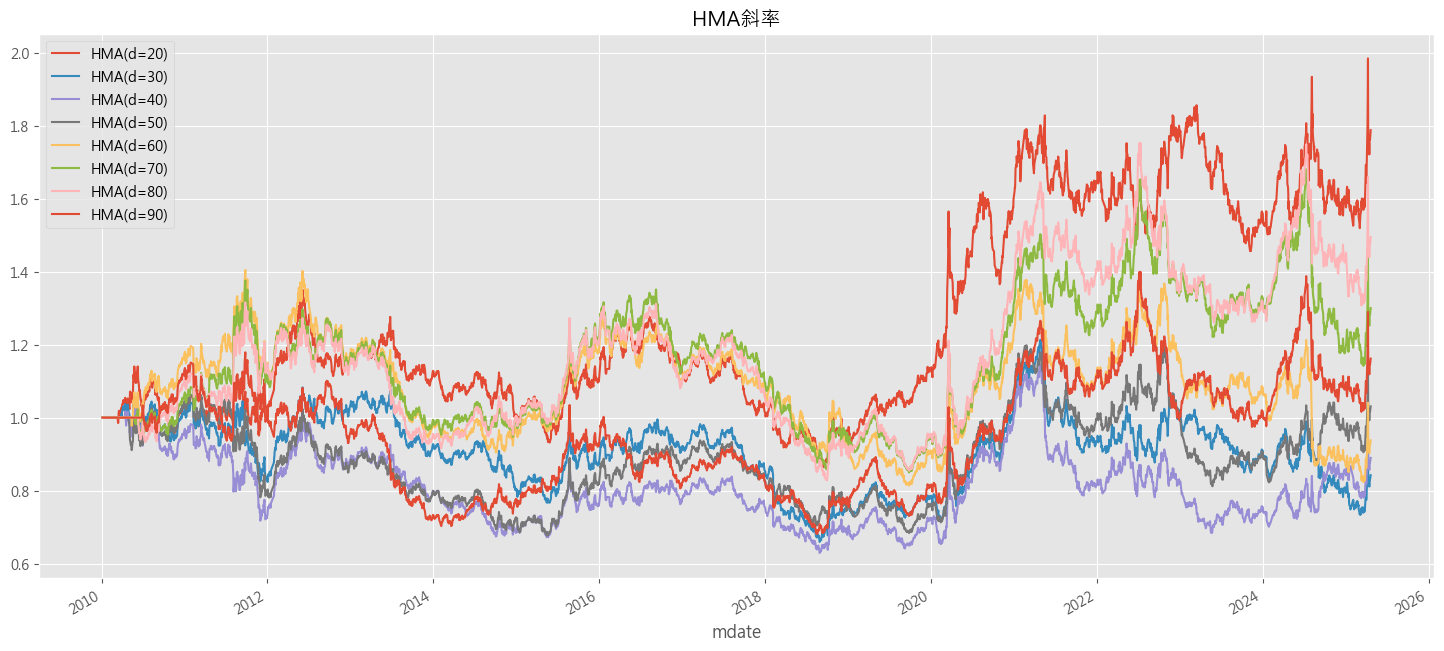

In [25]:
shope_df = hma_df[[f'HMA(d=%s)' % d for d in range(20, 91, 10)
                    ]].rolling(22).apply(
                        cal_shope, raw=True)
                        
cond = (shope_df > 1) * 1 + (shope_df < 1) * -1
strategy_ret_e = cond * ret_shape
strategy_cum_e = (1 + strategy_ret_e).cumprod()
strategy_cum_e.plot(figsize=(18,8),title='HMA斜率')

# 因子合成

In [26]:
llt_df = pd.DataFrame()
frama_df = pd.DataFrame()
hma_df = pd.DataFrame()

for d in range(20,91,10):
    
    llt_df[f'd%s'%d] = cal_LLT(price_df['close'],2/(d+1))
    frama_df[f'd%s'%d] = FRAMA(price_df['close'],d+60)
    hma_df[f'd%s'%d] = HMA(price_df['close'],d+60)
    
diff_llt = llt_df.diff().shift(1)
diff_llt.index = price_df.index
diff_frama = frama_df.diff().shift(1)
diff_hma = hma_df.diff().shift(1)

<Axes: xlabel='mdate'>

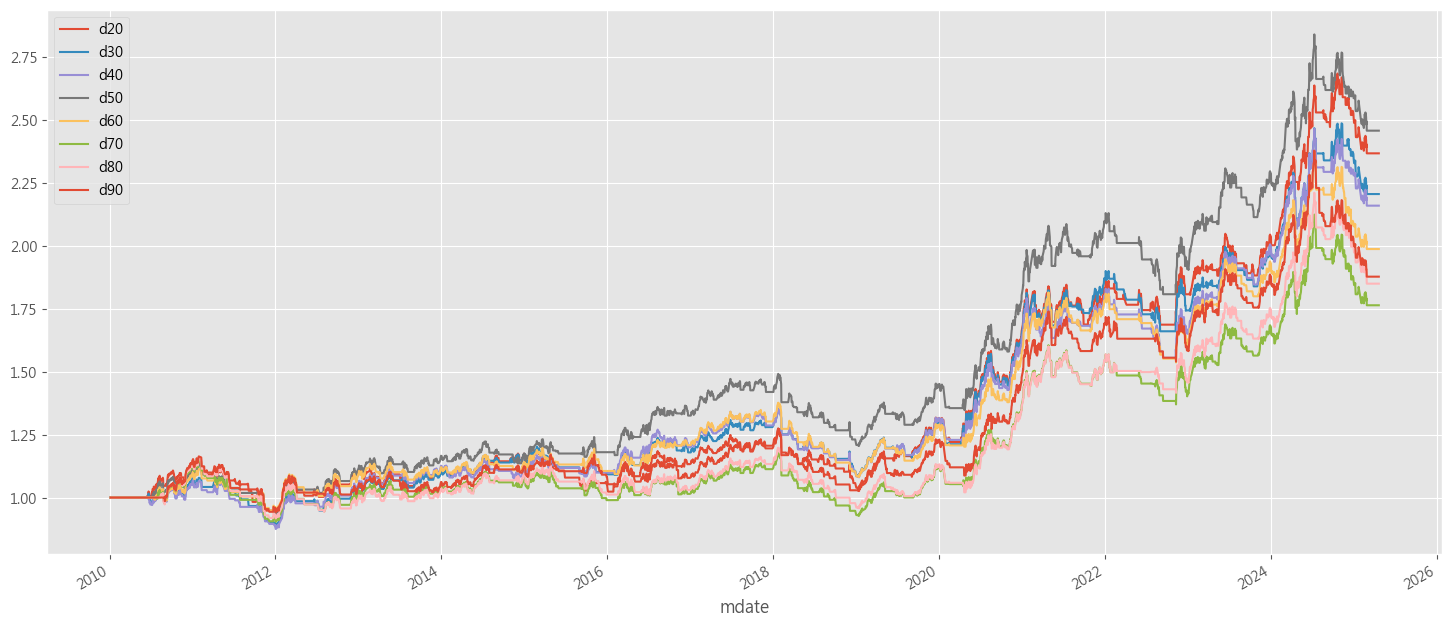

In [27]:
x_factor = (diff_llt+diff_frama+diff_hma)/3

cond = (x_factor>0)*1
(1+ret_shape*cond).cumprod().plot(figsize=(18,8))

<Axes: title={'center': 'X斜率'}, xlabel='mdate'>

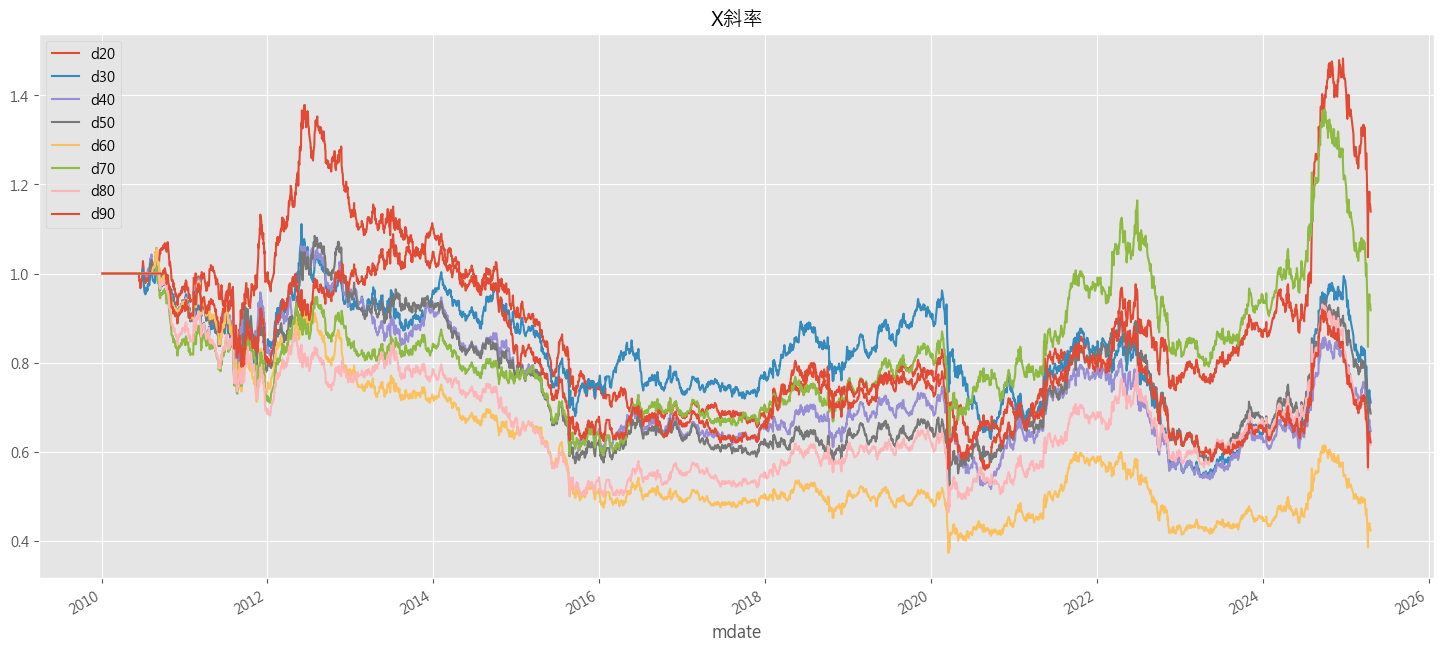

In [28]:
shope_df = x_factor[[f'd%s' % d for d in range(20, 91, 10)
                    ]].rolling(22).apply(
                        cal_shope, raw=True)
                        
cond = (shope_df > 1) * 1 + (shope_df < 1) * -1
strategy_ret_e = cond * ret_shape
strategy_cum_e = (1 + strategy_ret_e).cumprod()
strategy_cum_e.plot(figsize=(18,8),title='X斜率')

In [62]:
from src.LLT import LLTTrendStrategy,run_grid_search
from src import Tool

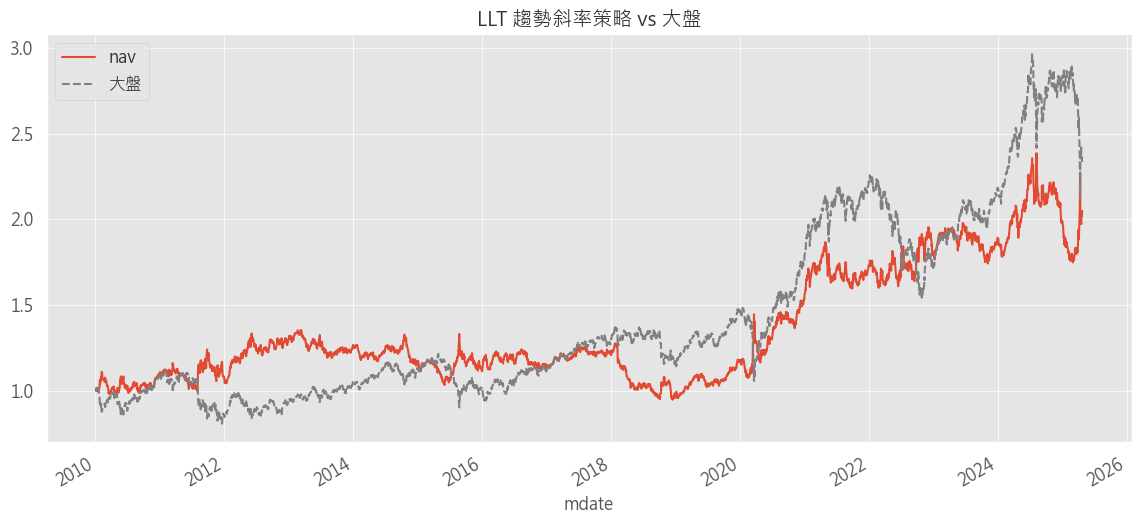

,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),样本胜率(%),周胜率(%),月胜率(%),年胜率(%),盈亏比(avg_win/avg_loss),总赚赔比(profit_factor),预期报酬(bps),样本数
策略,6.19,0.37,0.11,-30.05,-23.06,51.32,52.44,51.09,68.75,1.01,1.07,1.91,3749


In [67]:
strategy = LLTTrendStrategy(60)
bt_result = strategy.backtest(price_df['close'])

bt_result[['nav']].plot(figsize=(14,6), label='策略淨值')
(1 + price_df['close'].pct_change().fillna(0)).cumprod().plot(label='大盤', ls='--', color='gray')
plt.title('LLT 趨勢斜率策略 vs 大盤')
plt.legend()
plt.show()
Tool.show_stats(bt_result['strategy_return'])

In [66]:
result = run_grid_search(price_df['close'], d_range=range(20, 91, 5), split_date='2020-01-01')
display(result)

,d,ann_return_is,sharpe_is,mdd_is,ann_return_oos,sharpe_oos,mdd_oos
2,30,0.041326,0.285250,-0.225880,0.109809,0.550346,-0.308703
4,40,0.040163,0.277224,-0.287503,0.087972,0.440808,-0.284356
3,35,0.036431,0.251453,-0.286862,0.124931,0.626246,-0.254994
5,45,0.034647,0.239137,-0.284454,0.094859,0.475347,-0.274265
8,60,0.026497,0.182879,-0.300473,0.123246,0.617785,-0.267039
10,70,0.026015,0.179552,-0.290391,0.112118,0.561933,-0.276269
7,55,0.025751,0.177730,-0.300635,0.113174,0.567228,-0.267039
6,50,0.024445,0.168716,-0.283523,0.101394,0.508126,-0.284621
11,75,0.023840,0.164540,-0.287756,0.124653,0.624847,-0.276269
1,25,0.018654,0.128744,-0.356321,0.132520,0.664353,-0.288229
